In [1]:
import logging
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout

# Handwritten Digit Recognition

In this tutorial, we'll give you a step by step walk-through of how to build a hand-written digit classifier using the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset. For someone new to deep learning, this exercise is arguably the "Hello World" equivalent.

MNIST is a widely used dataset for the hand-written digit classification task. It consists of 70,000 labeled 28x28 pixel grayscale images of hand-written digits. The dataset is split into 60,000 training images and 10,000 test images. There are 10 classes (one for each of the 10 digits). The task at hand is to train a model using the 60,000 training images and subsequently test its classification accuracy on the 10,000 test images.

![png](https://raw.githubusercontent.com/dmlc/web-data/master/mxnet/example/mnist.png)

**Figure 1:** Sample images from the MNIST dataset.

## Prerequisites
To complete this tutorial, we need:  

- MXNet version 0.10 or later. See the installation instructions for your operating system in [Setup and Installation](http://mxnet.io/get_started/install.html).

- [Python Requests](http://docs.python-requests.org/en/master/) and [Jupyter Notebook](http://jupyter.org/index.html).

```
$ pip install requests jupyter
```

## Loading Data

Before we define the model, let's first fetch the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

The following source code downloads and loads the images and the corresponding labels into memory.

In [2]:
import mxnet as mx
mnist = mx.test_utils.get_mnist()

mnist["train_data"].shape

/home/yannick/bin/anaconda3/envs/py36/lib/python3.6/site-packages/urllib3/contrib/pyopenssl.py:46: DeprecationWarning: OpenSSL.rand is deprecated - you should use os.urandom instead
  import OpenSSL.SSL
INFO:root:train-labels-idx1-ubyte.gz exists, skipping download
INFO:root:train-images-idx3-ubyte.gz exists, skipping download
INFO:root:t10k-labels-idx1-ubyte.gz exists, skipping download
INFO:root:t10k-images-idx3-ubyte.gz exists, skipping download


(60000, 1, 28, 28)

After running the above source code, the entire MNIST dataset should be fully loaded into memory. Note that for large datasets it is not feasible to pre-load the entire dataset first like we did here. What is needed is a mechanism by which we can quickly and efficiently stream data directly from the source. MXNet Data iterators come to the rescue here by providing exactly that. Data iterator is the mechanism by which we feed input data into an MXNet training algorithm and they are very simple to initialize and use and are optimized for speed. During training, we typically process training samples in small batches and over the entire training lifetime will end up processing each training example multiple times. In this tutorial, we'll configure the data iterator to feed examples in batches of 100. Keep in mind that each example is a 28x28 grayscale image and the corresponding label.

Image batches are commonly represented by a 4-D array with shape `(batch_size, num_channels, width, height)`. For the MNIST dataset, since the images are grayscale, there is only one color channel. Also, the images are 28x28 pixels, and so each image has width and height equal to 28. Therefore, the shape of input is `(batch_size, 1, 28, 28)`. Another important consideration is the order of input samples. When feeding training examples, it is critical that we don't feed samples with the same label in succession. Doing so can slow down training.
Data iterators take care of this by randomly shuffling the inputs. Note that we only need to shuffle the training data. The order does not matter for test data.

The following source code initializes the data iterators for the MNIST dataset. Note that we initialize two iterators: one for train data and one for test data.

In [3]:
batch_size = 64
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

##  Now for vgg

In [4]:
from mxnet.symbol import Convolution, Activation, Pooling, Dropout, FullyConnected, var, flatten, SoftmaxOutput

In [5]:
data = var('data')

conv_arch = ((1,64), (1,128), (2,256), (2,512))
full_arch = (512, 512)


def vgg_block(x, num_convs, channels):
    for _ in range(num_convs):
        x = Convolution(data=x, num_filter=channels, kernel=(3,3), stride=(1,1), pad=(1,1))
        x = Activation(data=x, act_type="relu")
    x = Pooling(x, pool_type="max", kernel=(2,2), stride=(2,2), pad=(0,0))
    return x

def vgg_stack(x, architecture):
    for (num_convs, channels) in architecture:
        x = vgg_block(x, num_convs, channels)
    return x

def vgg_full(x, architecture, act_type="relu", p=0.5):
    for num_cell in architecture:
        x = FullyConnected(x, num_hidden=num_cell)
        x = Activation(x, act_type=act_type)
        x = Dropout(x, p=p)
    return x


x = data

x = vgg_stack(x, conv_arch)
x = flatten(x)
x = vgg_full(x, full_arch)
x = FullyConnected(x, num_hidden=10)
vgg = SoftmaxOutput(data=x, name='softmax')

vgg

<Symbol softmax>

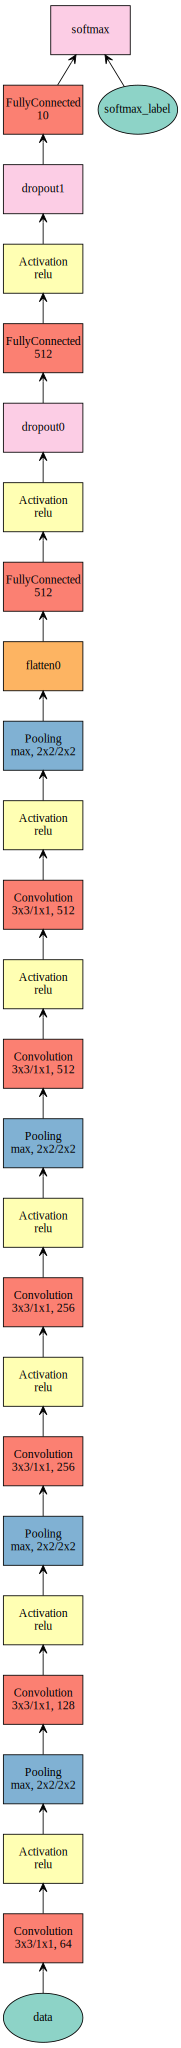

In [6]:
mx.viz.plot_network(vgg)

In [7]:
%%time

clf = mx.mod.Module(symbol=vgg, context=mx.gpu())

clf.fit(train_iter,
        eval_data=val_iter,
        initializer=mx.initializer.Xavier(magnitude=2.24),
        optimizer='sgd',
        optimizer_params={'learning_rate':0.05},
        eval_metric='acc',
        batch_end_callback = mx.callback.Speedometer(batch_size, 100),
        num_epoch=40)

INFO:root:Epoch[0] Batch [100]	Speed: 2439.65 samples/sec	accuracy=0.118502
INFO:root:Epoch[0] Batch [200]	Speed: 2428.57 samples/sec	accuracy=0.135469
INFO:root:Epoch[0] Batch [300]	Speed: 2402.39 samples/sec	accuracy=0.173750
INFO:root:Epoch[0] Batch [400]	Speed: 2439.47 samples/sec	accuracy=0.275625
INFO:root:Epoch[0] Batch [500]	Speed: 2427.05 samples/sec	accuracy=0.448125
INFO:root:Epoch[0] Batch [600]	Speed: 2391.80 samples/sec	accuracy=0.719688
INFO:root:Epoch[0] Batch [700]	Speed: 2416.94 samples/sec	accuracy=0.849844
INFO:root:Epoch[0] Batch [800]	Speed: 2435.63 samples/sec	accuracy=0.895938
INFO:root:Epoch[0] Batch [900]	Speed: 2431.14 samples/sec	accuracy=0.925937
INFO:root:Epoch[0] Train-accuracy=0.930743
INFO:root:Epoch[0] Time cost=24.837
INFO:root:Epoch[0] Validation-accuracy=0.953225
INFO:root:Epoch[1] Batch [100]	Speed: 2440.37 samples/sec	accuracy=0.944307
INFO:root:Epoch[1] Batch [200]	Speed: 2407.67 samples/sec	accuracy=0.951094
INFO:root:Epoch[1] Batch [300]	Speed:

INFO:root:Epoch[10] Batch [300]	Speed: 2434.17 samples/sec	accuracy=0.995781
INFO:root:Epoch[10] Batch [400]	Speed: 2464.68 samples/sec	accuracy=0.996406
INFO:root:Epoch[10] Batch [500]	Speed: 2428.52 samples/sec	accuracy=0.995938
INFO:root:Epoch[10] Batch [600]	Speed: 2438.69 samples/sec	accuracy=0.995938
INFO:root:Epoch[10] Batch [700]	Speed: 2422.75 samples/sec	accuracy=0.992812
INFO:root:Epoch[10] Batch [800]	Speed: 2446.45 samples/sec	accuracy=0.995313
INFO:root:Epoch[10] Batch [900]	Speed: 2440.51 samples/sec	accuracy=0.996875
INFO:root:Epoch[10] Train-accuracy=0.996199
INFO:root:Epoch[10] Time cost=24.646
INFO:root:Epoch[10] Validation-accuracy=0.991043
INFO:root:Epoch[11] Batch [100]	Speed: 2433.30 samples/sec	accuracy=0.995978
INFO:root:Epoch[11] Batch [200]	Speed: 2444.11 samples/sec	accuracy=0.995938
INFO:root:Epoch[11] Batch [300]	Speed: 2451.21 samples/sec	accuracy=0.995938
INFO:root:Epoch[11] Batch [400]	Speed: 2425.27 samples/sec	accuracy=0.995781
INFO:root:Epoch[11] Bat

INFO:root:Epoch[20] Batch [300]	Speed: 1776.79 samples/sec	accuracy=0.998594
INFO:root:Epoch[20] Batch [400]	Speed: 2126.99 samples/sec	accuracy=0.998125
INFO:root:Epoch[20] Batch [500]	Speed: 2392.58 samples/sec	accuracy=0.998750
INFO:root:Epoch[20] Batch [600]	Speed: 2416.21 samples/sec	accuracy=0.998281
INFO:root:Epoch[20] Batch [700]	Speed: 2417.31 samples/sec	accuracy=0.998125
INFO:root:Epoch[20] Batch [800]	Speed: 2381.22 samples/sec	accuracy=0.999531
INFO:root:Epoch[20] Batch [900]	Speed: 2389.87 samples/sec	accuracy=0.998594
INFO:root:Epoch[20] Train-accuracy=1.000000
INFO:root:Epoch[20] Time cost=27.511
INFO:root:Epoch[20] Validation-accuracy=0.991839
INFO:root:Epoch[21] Batch [100]	Speed: 2378.81 samples/sec	accuracy=0.999536
INFO:root:Epoch[21] Batch [200]	Speed: 1912.18 samples/sec	accuracy=0.998594
INFO:root:Epoch[21] Batch [300]	Speed: 1560.57 samples/sec	accuracy=0.999844
INFO:root:Epoch[21] Batch [400]	Speed: 2056.74 samples/sec	accuracy=0.998906
INFO:root:Epoch[21] Bat

INFO:root:Epoch[30] Batch [300]	Speed: 2381.29 samples/sec	accuracy=0.999375
INFO:root:Epoch[30] Batch [400]	Speed: 2426.59 samples/sec	accuracy=1.000000
INFO:root:Epoch[30] Batch [500]	Speed: 2388.78 samples/sec	accuracy=0.999687
INFO:root:Epoch[30] Batch [600]	Speed: 2423.24 samples/sec	accuracy=0.999844
INFO:root:Epoch[30] Batch [700]	Speed: 2434.35 samples/sec	accuracy=0.999531
INFO:root:Epoch[30] Batch [800]	Speed: 2429.62 samples/sec	accuracy=0.999687
INFO:root:Epoch[30] Batch [900]	Speed: 2386.16 samples/sec	accuracy=1.000000
INFO:root:Epoch[30] Train-accuracy=0.999155
INFO:root:Epoch[30] Time cost=25.179
INFO:root:Epoch[30] Validation-accuracy=0.991541
INFO:root:Epoch[31] Batch [100]	Speed: 2445.52 samples/sec	accuracy=0.999072
INFO:root:Epoch[31] Batch [200]	Speed: 2417.67 samples/sec	accuracy=0.999844
INFO:root:Epoch[31] Batch [300]	Speed: 2433.36 samples/sec	accuracy=0.999219
INFO:root:Epoch[31] Batch [400]	Speed: 2397.44 samples/sec	accuracy=0.999844
INFO:root:Epoch[31] Bat

CPU times: user 17min 49s, sys: 2min 17s, total: 20min 7s
Wall time: 17min 54s
